# Miniproject 2: Chatbot

## Introduction

### Description

Developing a model employing ANN on real-world data requires going through several major steps, each of which with 
important design choices that directly impact the final results. 
In this project, we guide you through these choices starting from a large database of 
[conversations](http://parl.ai/downloads/personachat/personachat.tgz) to a functional chatbot. 

### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "recurrent neural networks", "LSTM", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will be guided through a data processing procedure and understand the importance of design choices in ANN modeling
- You will learn how to define recurrent neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed in the lecture, like "overfitting", "LSTM network", and "Generative model".
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night and make sure you save (and load) your data and models.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook. 
Please ensure that your notebook is fully executed before handing it in. 

### Submission 

You should submit your notebook through the Moodle page submission tool. You should work in teams of two people and each member should submit the same notebook to Moodle.



## Functions and imports

For your convenience we import some libraries and provide some functions below. Fill in your names, sciper numbers and run the following cell.

In [1]:
names = {'student_1': "Marshall Cooper",
        'student_2': "Andrea Piccione"}

sciper = {'student_1': 299656, 
          'student_2': 294045}

seed = sciper['student_1']+sciper['student_2']

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os, sys
import copy
import pickle

plt.rcParams['font.size'] = 28
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
c = plt.rcParams['axes.prop_cycle'].by_key()['color']

import keras
from keras.models import Model, load_model
from keras.layers import Input, Masking, TimeDistributed, Dense, Concatenate, Dropout, LSTM, GRU, SimpleRNN, Bidirectional, Embedding, BatchNormalization
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, EarlyStopping


def getRawDataFromFile(datapath="../data/personachat/", file="train_both_revised.txt"):
    
    f = open(datapath+file)

    conversations = []
    current_conversation = []
    
    for l, line in enumerate(f):
        #print(l, line)
        if "persona:" in line:
            if len(current_conversation) > 1:
                conversations.append(current_conversation)
            current_conversation = [] 
            continue

        #remove numberings
        processed_line = line.split(' ')
        processed_line = " ".join(processed_line[1:])
        line = processed_line
        #print(line)

        conv = line.split('\t')    
        q = conv[0]
        a = conv[1]
        current_conversation.append(q)
        current_conversation.append(a)
    
    return conversations 

Using TensorFlow backend.


## Data visualization and preprocessing

Here we will process and visualize the data.


### Parse raw data 

Download the dataset on http://parl.ai/downloads/personachat/personachat.tgz. Unpack it and add it to your project folder. Read and run the getRawDataFromFile function (if needed, modify the default path). It extracts the conversations.

**Output** Display two randomly selected conversations. [1 pt]

In [2]:
import random
conversations = getRawDataFromFile()
random.choices(conversations, k=2)

[['so , star wars is the greatest movie of all time . its my favorite .',
  'i watch star wars when i work in my flower shop .',
  'that is awesome ! my iguana is named boba fett !',
  'awesome . my cats name is penelope . i adore cats',
  'oh i love that name ! super cute ! do you like video games ?',
  'yes , but i love to read used books mainly .',
  'why used books ? i play so many star wars video games .',
  'i am broke . i live in my parents basement , so no extra money .',
  'oh , why not the library then ?',
  'its to quiet and i like to eat',
  'i am employed at mcdonald ! food is good .',
  'i cant eat meat only veggies',
  'personal reasons ? or you just do not like meat ? french fries are a veggie',
  'i love french fries .'],
 ['hello friend , how are you today ?',
  'i am well and you ?',
  'i am doing great . getting ready for a family reunion .',
  'how fun ! i am hanging out with my 3 dogs and 2 children',
  'full house here too . i have 6 brothers and sisters , we wer

### Extract word tokens

Let's start looking at our data. 

**Code** Compute the set of unique words (dictionary) in all sentences along with the number of occurences of each of these words. HINT: each word is separated by a space character, use the python string.split(' ') function to separate words. Consider punctuations as 'words'. [1 pt]

**Figure** In a bar plot, show the first 75 most frequent words (x-axis) and their number of occurences (y-axis). [1 pt]

**Figure** In another bar plot, show the 75 least frequent words (x-axis) and their number of occurences (y-axis). [1 pt] 

**Figure** In a log-log scale, plot the sorted word index (x-axis) vs their respective count (y-axis). [1 pt]

**Question** Relate the sorted word count distribution with Zipf's law.
Argue using the log-log plot. [1 pt]

**Answer** Zipf's law asserts an inverse proportional relationship between frequency and word rank within a natural language vocabulary. The evidence of this particular relation (as opposed to some other shrinking distribution that is not "Zipfian") is shown by the linearization of such a relation under log-log axes. In our log-log plot we see what resembles a line, although we note that it is not perfectly linear. It is close enough that we consider this ordering to align with Zipf's law.

**Question** How many words appear only once in the entire dataset? [1 pt]

**Answer** 7080



In [3]:
# Get word-count
from collections import Counter
cnt = Counter()
for c in conversations:
    for s in c:
        cnt.update(s.split(' '))

In [4]:
# Most frequent words
frequent_words = cnt.most_common(75)
keys = [i[0] for i in frequent_words]
values = [i[1] for i in frequent_words]

<BarContainer object of 75 artists>

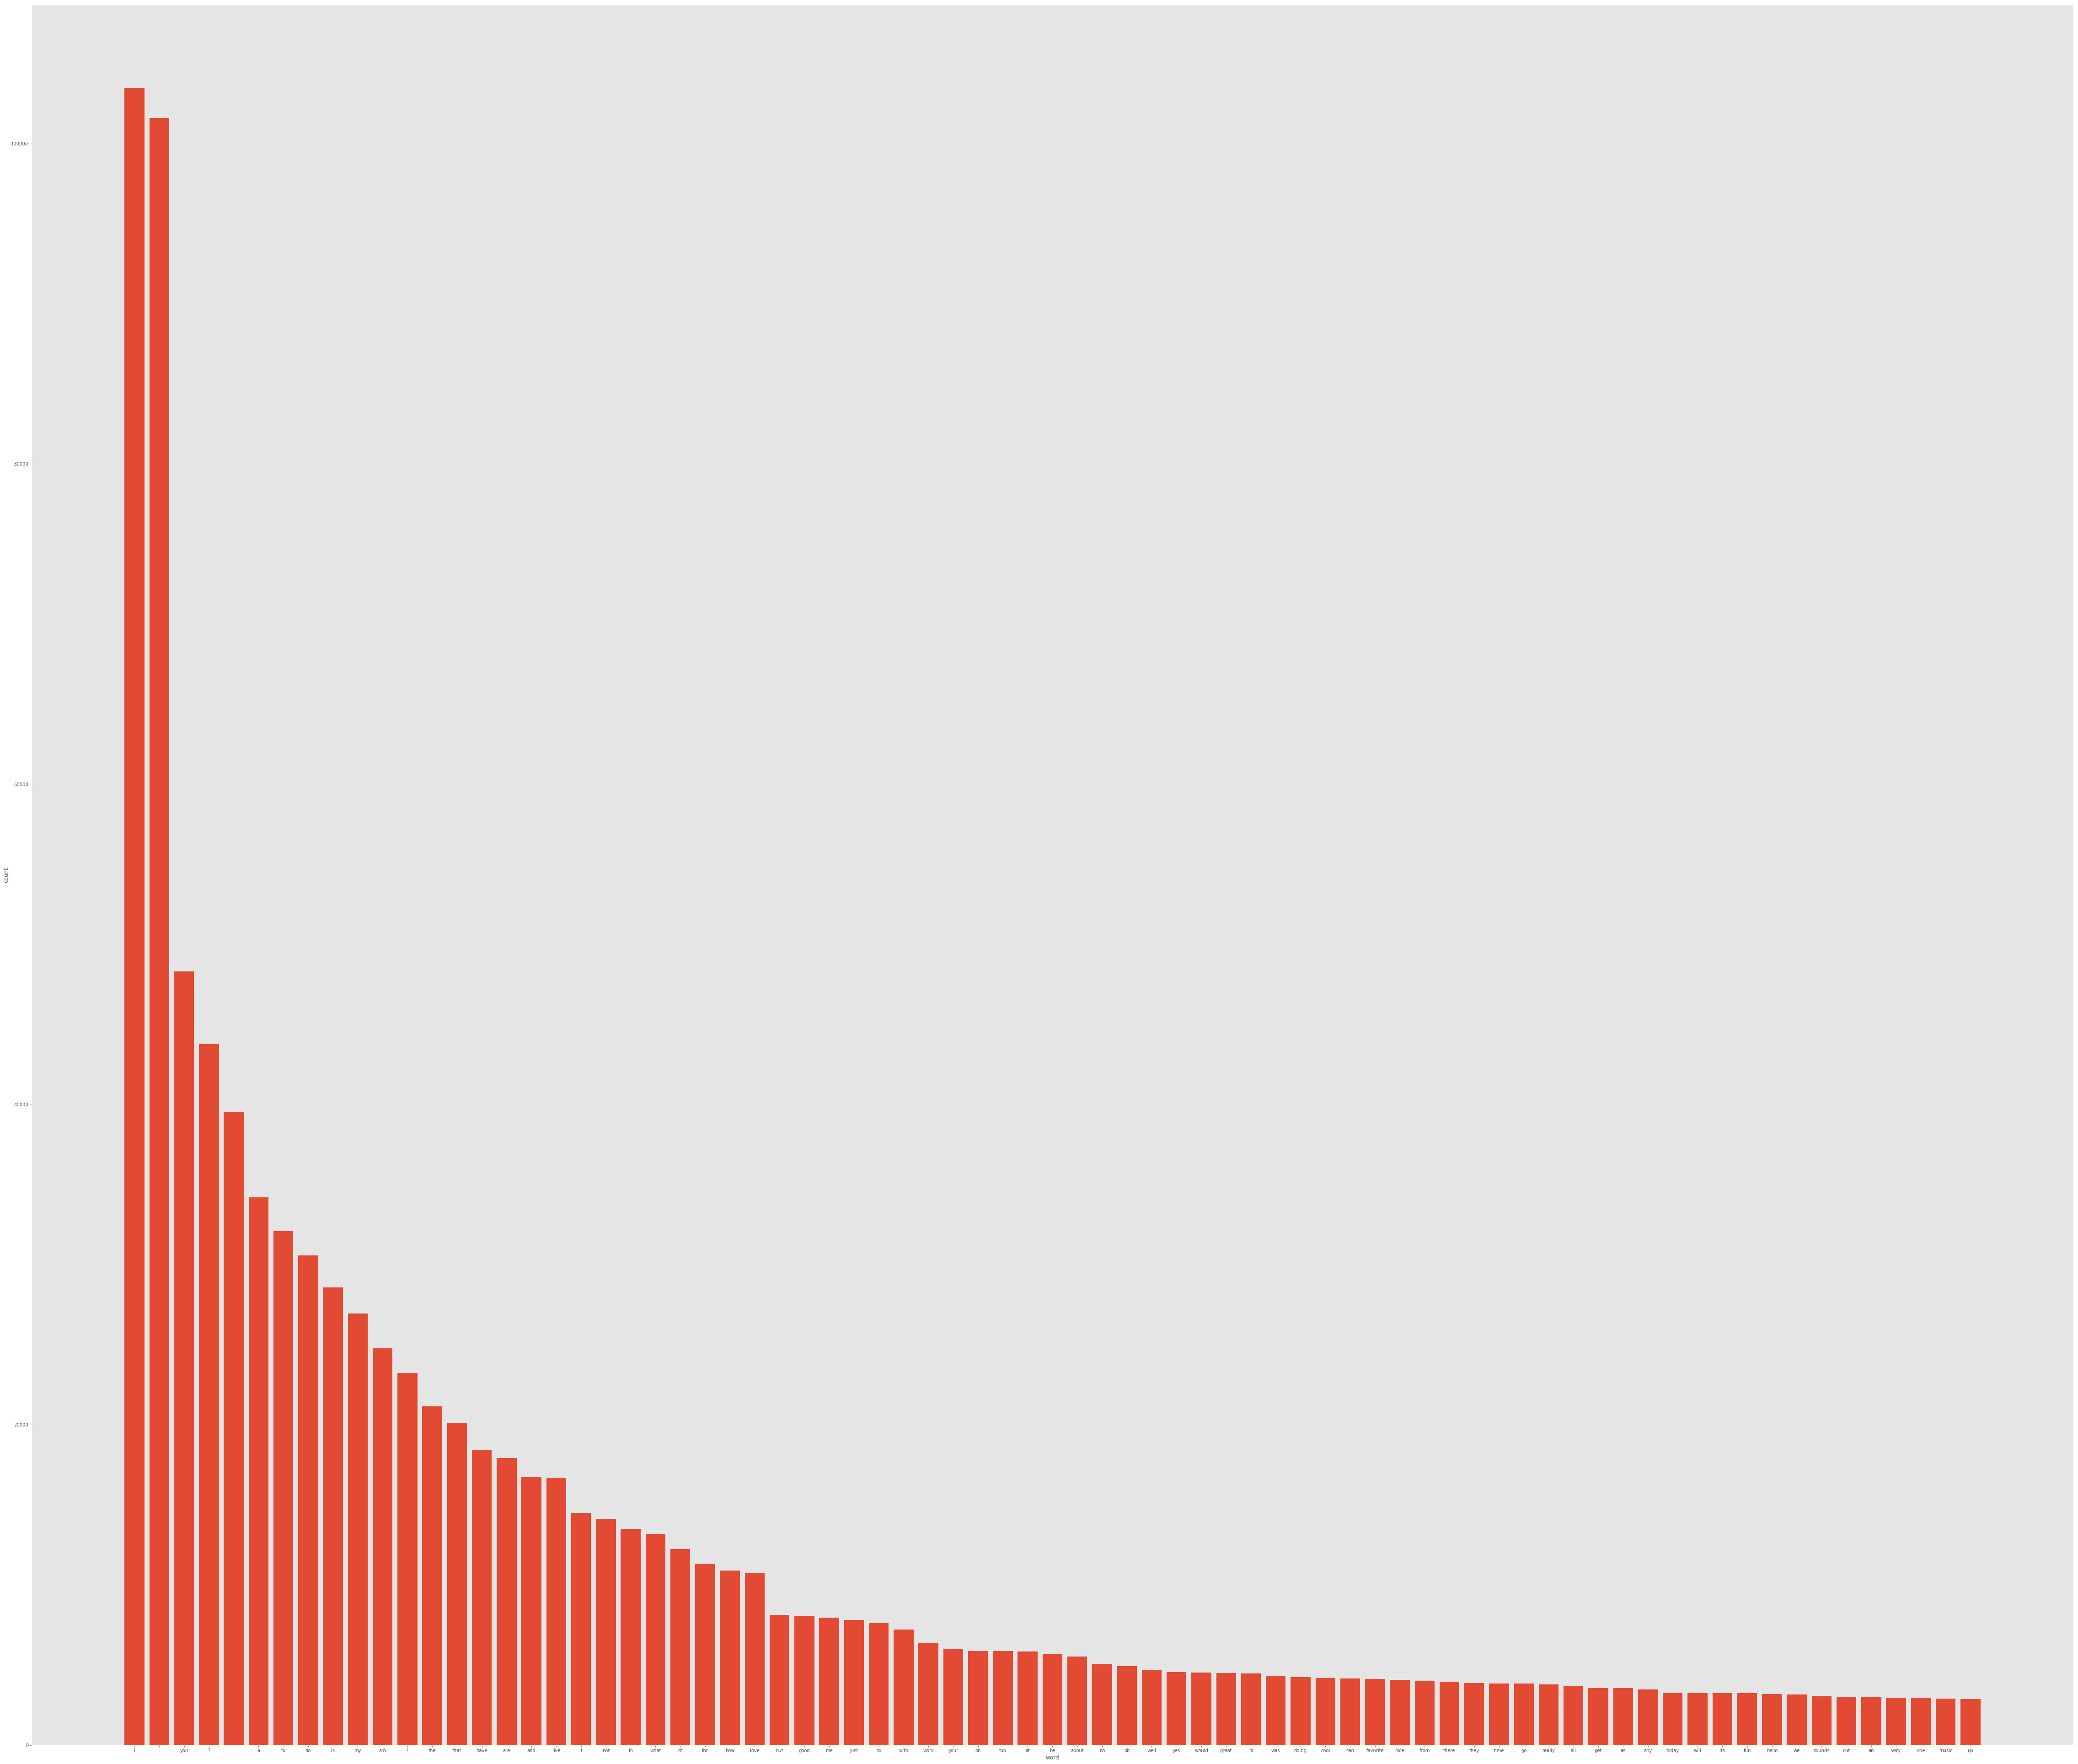

In [5]:
# Plotting
plt.figure(figsize=(80,70))
plt.xlabel("word")
plt.ylabel("count")
plt.bar(keys, values)

In [6]:
# Least Frequent words
unfrequent_words = cnt.most_common()[-76:-1]
keys = [i[0] for i in unfrequent_words]
values = [i[1] for i in unfrequent_words]

<BarContainer object of 75 artists>

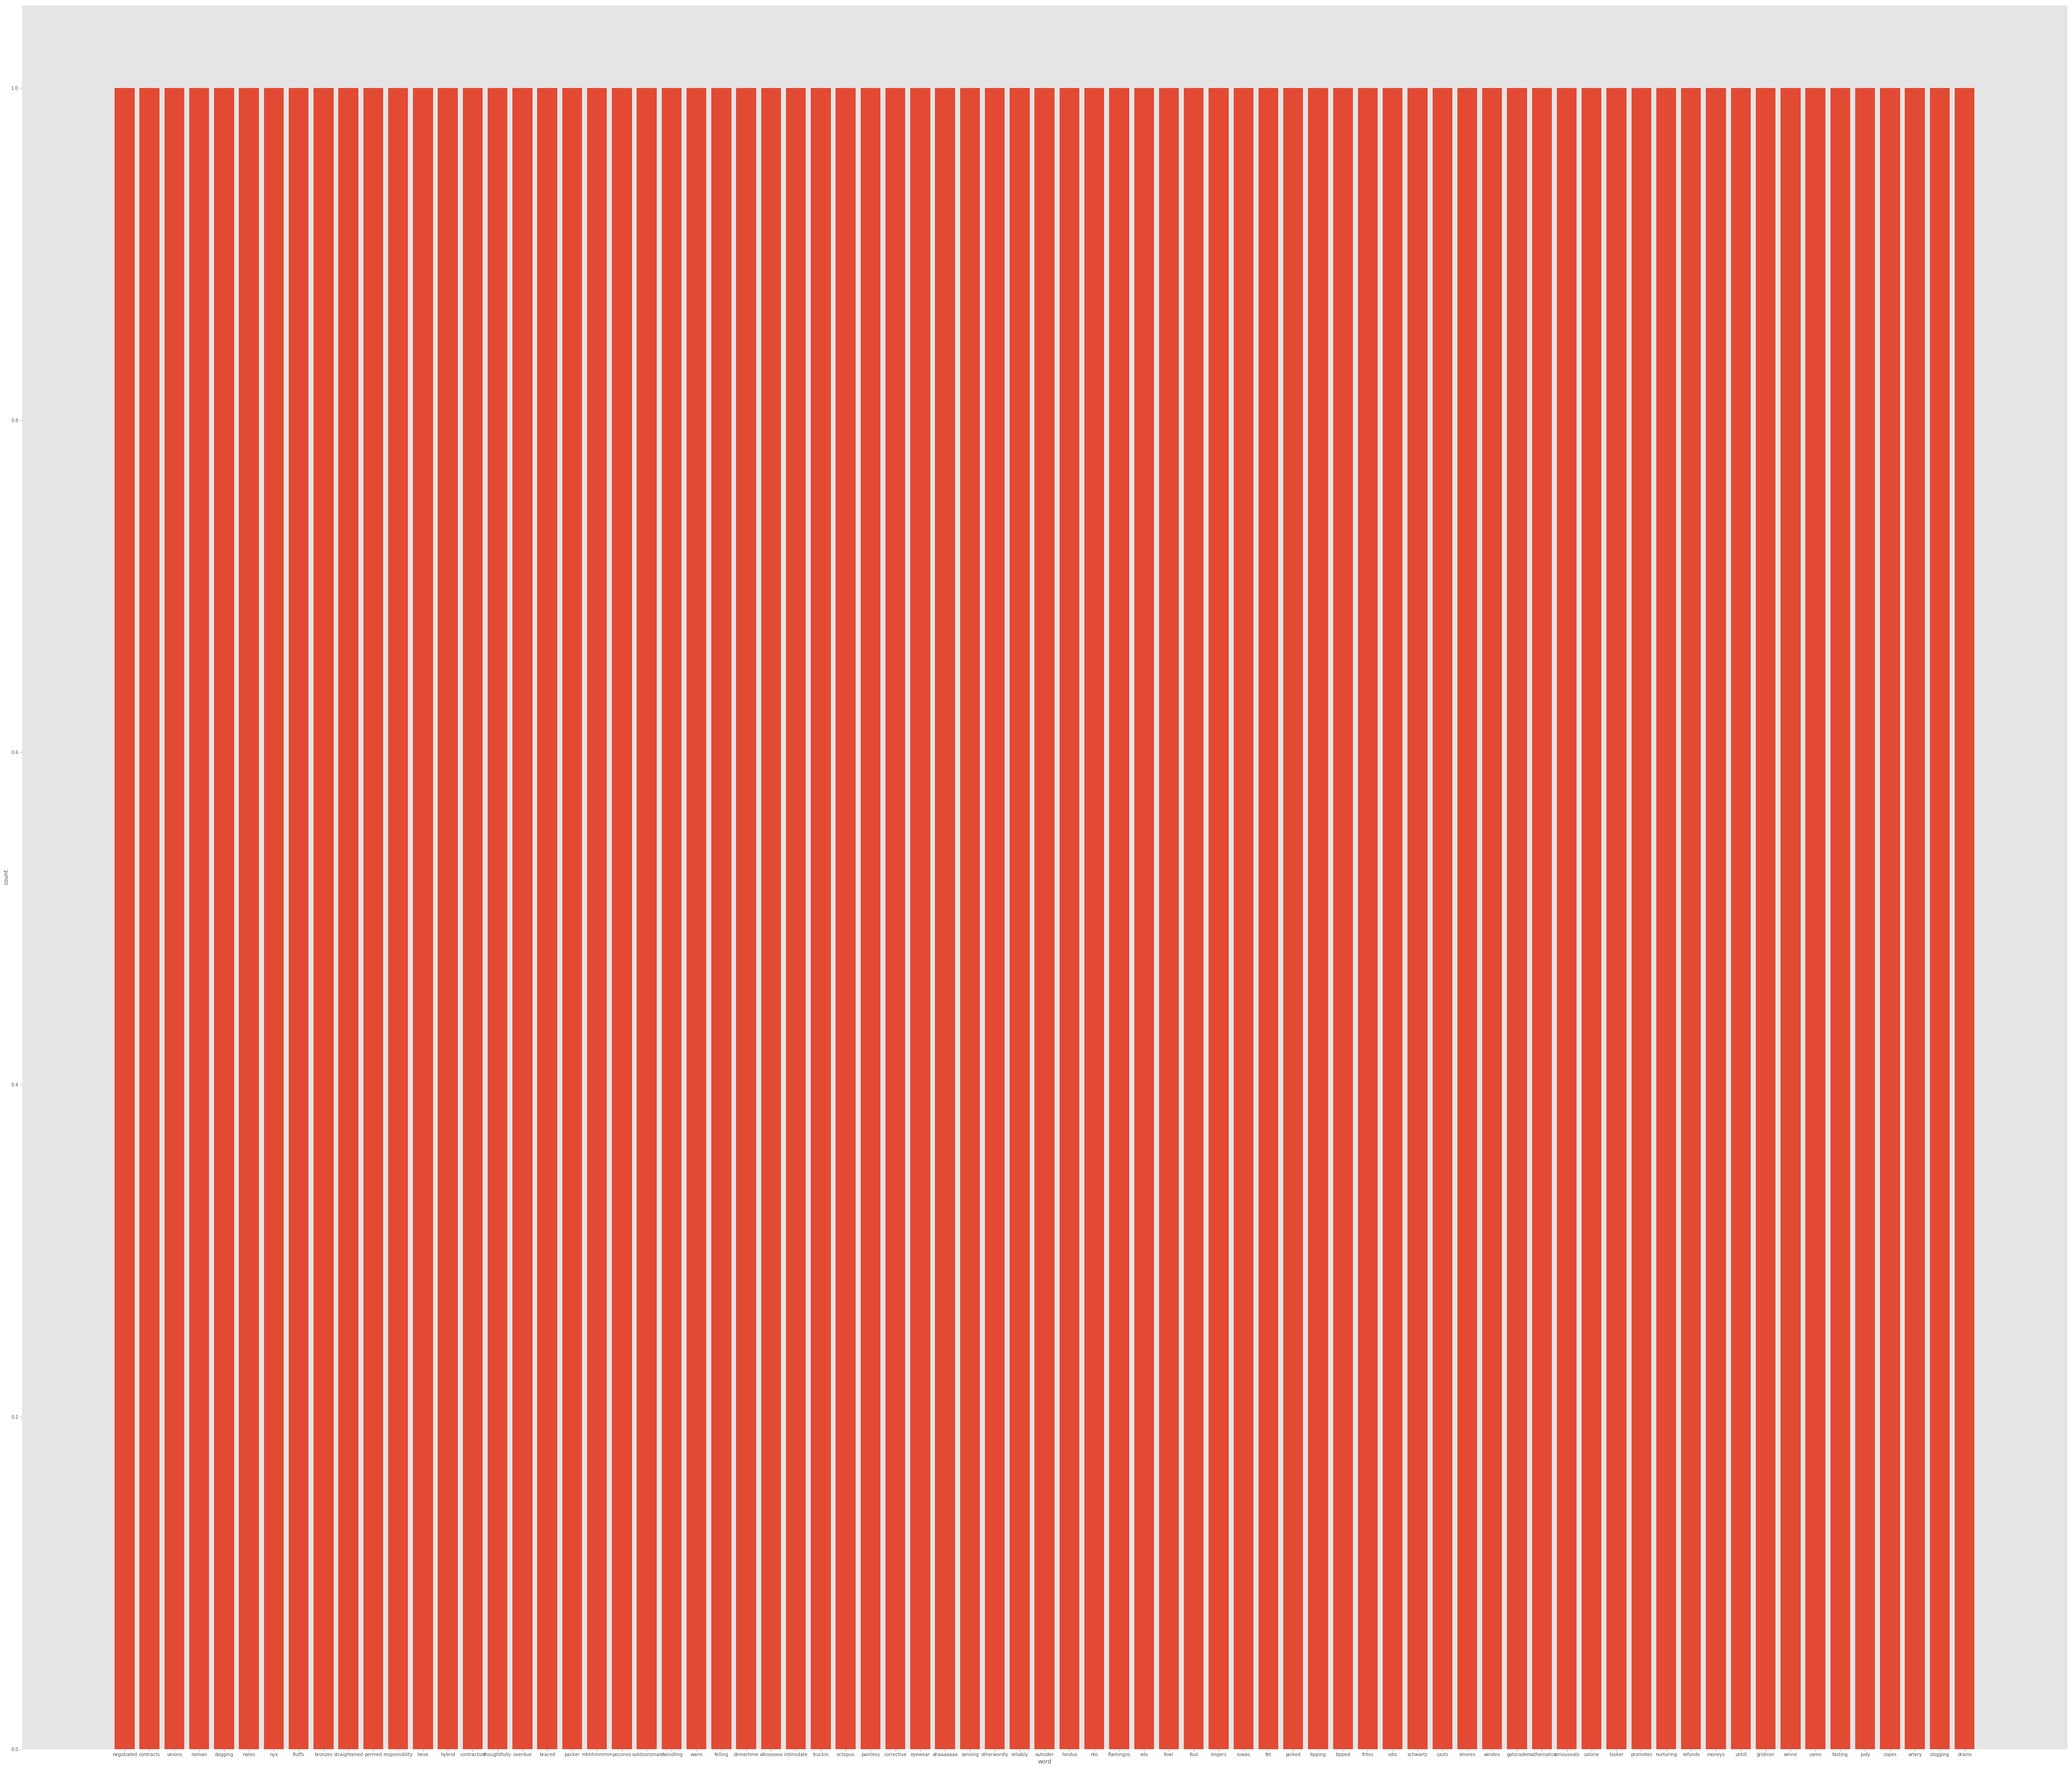

In [7]:
# Plotting
plt.figure(figsize=(80,70))
plt.xlabel("word")
plt.ylabel("count")
plt.bar(keys, values)

In [8]:
values = [i[1] for i in cnt.most_common()]

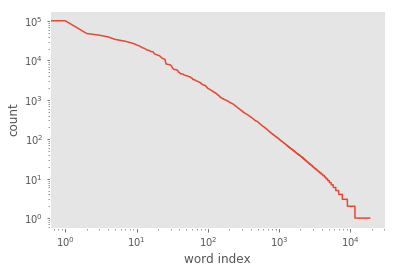

In [9]:
plt.xlabel("word index")
plt.ylabel("count")
plt.loglog(range(len(cnt.most_common())), values)

In [10]:
ones = [w for w in cnt if cnt[w] == 1]
print("Number of words appearing only ones: " + str(len(ones)))

Number of words appearing only ones: 7080


### Filtering

We suggest to filter your data by removing sentences containing rare words. 


**Code** To achieve that, you should create a new dataset where sentences containing rare words (words that occur less than N times in the dataset) are removed. Keep at least 50'000 sentences (depending on your computing power, you can keep more). 
HINT: Start by updating the dictionary accordingly and then remove any sentence that contains at least a single word that is not in the dictionary of words. [2 pts]

**Question**: How much did you reduce the number of unique words with your rare event suppression procedure? [1 pt]
    
**Answer**: 18673 words were pruned -> 1007 words, approximately 94% reduction.

**Question**: How many sentences are in your filtered and original dataset? [1 pt]

**Answer**: 131424 sentences -> 50793 sentences including only words that appear more than 100 times.

**Question**: What is the impact on learning and generalization of removing sentences with rare words from your dataset? [2 pt]

**Answer**: In the most extreme case, we can consider a word that only appears one time as having only a single transition (to the word that appears after it) that it can teach the learner. This should be easy to learn for the model, as it will always incur little loss for predicting that transition with high certainty, but this will not generalize well since the word may have more diverse usage that is not witnessed in the training data. In short, we expect that rare words should improve training performance (loss/accuracy) but worsen generalization, and we remove sentences containing them because we want the model to generalize well.

In [11]:
words = cnt

In [12]:
# Declare N and threshold of remaining sentences
threshold = 50000
# Update dictionary
filtered = conversations
N = 0
prev = filtered
pruned = dict([(i, words[i]) for i in words if words[i]>N])
total = sum([len(i) for i in filtered])
while(total>threshold):
    prev = (filtered, pruned, N)
    N += 50
    pruned = dict([(i, words[i]) for i in words if words[i]>N])
    filtered = [i for i in [[sentence for sentence in conversation if all([word in pruned.keys() for word in sentence.split(' ')])] for conversation in conversations] if i!=[]]
    total = sum([len(i) for i in filtered])
    print("Filtering N = {0} : {1} sentences remaining N.".format(N, total))

    
filtered, pruned, N = prev
total = sum([len(i) for i in filtered])
print("Using N = {0}".format(N))
print("{0} words originally, reduced to {1}: {2}% reduction.".format(len(words), len(pruned), int(100*(1-(len(pruned)/len(words))))))

Filtering N = 50 : 66500 sentences remaining N.
Filtering N = 100 : 50793 sentences remaining N.
Filtering N = 150 : 41527 sentences remaining N.
Using N = 100
18673 words originally, reduced to 1007: 94% reduction.


### Tokenization and padding

Now you will transform our filtered data into a format that is understandable by an ANN. To achieve that, you should transform words to integers, where single integers in the range [1,size of the dictionary] are mapped to single words in your dictionary. This process is commonly named 'tokenization'. In addition, we will keep the value 0 to a specific artificial word 'PADD' that will be used to account for the variable length of sentences and add to each sentence a 'START' and an 'END' word. 

**Code** Start by adding the three artificial words to your dictionary (list of possible tokens) and then translate every sentences to a list of integers. 
HINT: use the Python List index() method. [2 pts]

**Figure** Use the violinplot to show the density of tokenized sentences length. [1pt]

**Code** From this figure, select a maximum number (=maxlen) of tokens for which most of the sentences have less. Padd (and eventually truncate) all sentences with the 'PADD' token (value 0 in the integer representation) until all tokenized sentences have the same length (maxlen).
HINT: use the pad_sequences function from keras.preprocessing.sequence [2 pts]

**Code** Check that you can recover the original sentence. Randomly select two sentences from your integer and padded representation and translate them back using your dictionary. [1 pt]

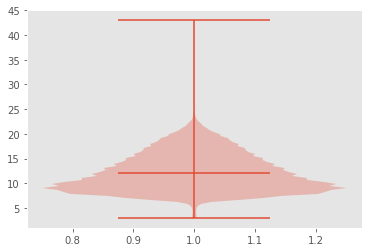

In [13]:
## Generate tokens
tokens = ['PADD', 'START', 'END'] + list(pruned.keys())

## Tokenize the input
tokenized = [[[tokens.index(word) for word in ['START'] + sentence.split(' ') + ['END']] for sentence in conversation] for conversation in filtered]

## Count lengths of each sentence
lens = Counter()
[lens.update([len(sentence) for sentence in conversation]) for conversation in tokenized]

## Plots
_ = plt.violinplot([i for i in lens.elements()], showmeans=True)

In [14]:
## Visually it appears as if 20 is a reasonable cutoff
maxlen = 20
## Generate padded sequences; create a flat representation as well
padded = [pad_sequences(conversation, maxlen) for conversation in tokenized]
padded_flat = [sentence for conversation in padded for sentence in conversation]
padded_flat[:5]

[array([ 0,  0,  0,  0,  1,  7, 20, 21, 22, 23, 19, 24, 25, 26, 27, 28, 29,
        30, 19,  2], dtype=int32),
 array([ 0,  0,  0,  1, 40, 25, 45, 19, 15,  7, 46, 47, 29, 48, 35, 49, 27,
        50,  9,  2], dtype=int32),
 array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 56, 25, 57, 29, 52, 14,
        55,  9,  2], dtype=int32),
 array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  3,  4,  5,  6,  7,  8,
        67,  9,  2], dtype=int32),
 array([ 0,  0,  0,  0,  0,  1, 10, 11, 80, 49, 81, 28, 82, 83, 56,  6,  7,
        84, 14,  2], dtype=int32)]

In [15]:
## Randomly select sentences to recover. Use tokens[i] for each integer i in the padded representation
to_recover = [padded_flat[i] for i in np.random.randint(0, len(conversations),size=2)]
[" ".join([tokens[i] for i in sentence if i>2]) for sentence in to_recover]

['that is awesome ! healthy is good for me !',
 'my computer is at the lake , where i read my horror novels i like come visit .']

### Saving

Now is a good time to save your data (end of processing). An example code using the pickle library is shown below.


In [30]:
import pickle

#save
with open("data.pkl", "wb") as file:
    pickle.dump([filtered, words, tokens], file)
    
#load
with open("data.pkl", "rb") as file:
    [filtered, words, tokens] = pickle.load(file)

## Building and training generative models of language

### RNN vs LSTM vs GRU 

Build, train and compare generative models of language based on RNNs with different recurrent units (SimpleRNN, GRU and LSTM). 

The target of the network will be to approximate the word transition probabilities Pr(word[n+1]|H[n]) with H[n]=f(word[:n]) being the hidden state of the network.  

**code** You should complete the proposed model (using the Keras API rather than the Sequential model for more flexibility). Be sure to understand each line. The embedding layer allows to transform an integer to a dense vector. That would be our input to the recurrent network - each sentence is mapped to a sequence of vectors, each representing a single word. You can then design your own readout(s) and output layers. By default, use the proposed meta parameters. You can adapt them if you have more or less computing power (32 epochs should take around 30 minutes). [2 pts]

**Question** How will your networks deal with the artificial word 'PADD' that you added at the end of each sentences  [2 pts]

**Answer** In theory, encountering 'PADD' at any given time step should predict a subsequent 'PADD' with high certainty, since all instances of 'PADD' lead to 'PADD' within the dataset (this is because we chose to 'post' pad the sequences). In practice, in utilizing the model, we terminate generation of news words if we encounter 'END', meaning that we will never use the model to generate transition probabilities following a 'PADD' time step, even though the model should compute these.

**code** Then train three different networks with the same architecture but using different recurrent units (simpleRNN, GRU and LSTM). Save the learning history (training/validation loss and accuracy for each epoch) as well as the models. [1 pt]

**Question** How can you use this network to approximate the word transition probabilities? What will be the inputs and targets of the network at each batch? Give the input/output tensor dimensions. [2 pts]

**Answer** We input a (n, maxlen-1) matrix to our model, where n is the number of sentences we want to process, and maxlen-1 is determined as all time steps a sequence, post-padded, up to the penultimate time step. It will predict a (n, maxlen-1, d) tensor, where d is size of the vocabulary. The interpretation for this output tensor is that for each sentence and time step it is producing the transition probabilities for the upcoming timestep. For example, the d-dimension distribution at (1, 4, :) predicts the probability distribution of the 5th word in the first sentence.

**Figure** Show the learning curves (training and validation loss) for the different recurrent units. [1 pt]

**Figure** Show the learning curves (training and validation accuracy) for the different recurrent units. [1 pt]

**Question:** Which recurrent unit yields the best validation accuracy? Which is the fastest learner? [1 pt]

**Answer**: LSTM and GRU yield nearly equivalent validation accuracy, both higher than SimpleRNN. GRU is the fastest learner.

**Question:** Do you observe an overfitting effect? Where and for which case? Give a possible explanation. [1 pt] 

**Answer**: TODO : We notice that SimpleRNN tends to overfit for high epochs (TODO: actual place where overfitting is observed). Processing more and more epochs gives the network the opportunity to 'memorize' the model, which improves training performance but worsens generalization.

**Question:** Suggest one option modifying your dataset to decrease overfitting. [1 pt]

**Answer**: Applying some type of rule-based augmentation of the dataset could decrease overfitting by adding more conflicting examples for the model to try to learn. An example of this kind of augmentation would be generating new sentences by interchanging adjectives in sentences.

**Question:** Suggest one possible option modifying your network to decrease overfitting. [1 pt]

**Answer**: Dropout could be used to decrease overfitting.

**Question:** Suggest one possible option modifying the training modalities to counter overfitting. [1 pt]   

**Answer**: Running for fewer epochs should decrease overfitting, since each epoch is a pass of the data and gives the network the opportunity to 'memorize' the training data better.

In [16]:
#Meta-parameters
embedding_size = 128
hidden_size = 64
dropout = 0.
recurrent_dropout = 0.

batch_size = 64
epochs = 32
validation_split = 0.2

dataset_cut = -1

In [17]:
I = {}
E = {}
H = {}
R = {}
Y = {}
models = {}
logs = {}

In [18]:
## Let X be the list of sentences: NxM where N is number of sentence, M is max length of pad
X = np.array(padded_flat)
## Let T be the one-hot encoding of X: NxMxD where D is the length of the vocabulary
## T[n,m,d] = 1 only when mth word of the nth sentence is the dth word of the vocabulary
T = np.zeros(X.shape + (len(tokens),))
for i, sentence in enumerate(X):
    for j, word in enumerate(sentence):
        T[i,j,word] = 1

In [19]:
def load_custom_model(model, layers, hidden_size):
    key = model + "_" + str(layers) + "_" + str(hidden_size) + "_" + +str(embedding_size)
    
    with open(key+"_log.pkl", "rb") as file:
        model_log = pickle.load(file)
    model = load_model(key)
    return model

In [20]:
def train_custom_model(model, layers, hidden_size):
    
    key = model + "_" + str(layers) + "_" + str(hidden_size) + "_" +str(embedding_size)
    
    I[key] = Input(shape=(maxlen-1,), name="input")
    E[key] = Embedding(len(tokens), embedding_size, embeddings_initializer=keras.initializers.Constant(best_embedding[0]), mask_zero=True, name="embedding", trainable=False)(I[key])
    
    H[key] = getattr(keras.layers, model)(hidden_size, return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout)(E[key])
    
    for i in range(2,layers+1):            
        H[key] = getattr(keras.layers, model)(hidden_size, return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout)(H[key]) #... Recurrent layer(s)
        
    R[key] = TimeDistributed(Dense(embedding_size, activation='relu'), name='readout')(H[key])   #... Readout
    Y[key] = TimeDistributed(Dense(len(tokens), activation='softmax'), name='output')(R[key]) #... Output

    models[key] = Model(inputs = [I[key]], outputs = [Y[key]])
    models[key].compile(
        loss='categorical_crossentropy', 
        optimizer=Adam(),
        metrics=['acc'])
    models[key].summary()
    
    es = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=2)
    
    print(X[:,:-1].shape, T[:,1:].shape)
    logs[key] = models[key].fit({'input': X[:dataset_cut,:-1]}, {'output': T[:dataset_cut,1:]}, 
                                        epochs=epochs, 
                                        validation_split=validation_split, 
                                        batch_size=batch_size,
                                        callbacks=[es]).history

    #save
    with open(key + "_log.pkl", "wb") as file:
        pickle.dump(logs[key], file)
    models[key].save(key)

In [156]:
# SimpleRNN
train_custom_model("SimpleRNN", 1, hidden_size)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 19)                0         
_________________________________________________________________
embedding (Embedding)        (None, 19, 128)           129280    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 19, 64)            12352     
_________________________________________________________________
readout (TimeDistributed)    (None, 19, 128)           8320      
_________________________________________________________________
output (TimeDistributed)     (None, 19, 1010)          130290    
Total params: 280,242
Trainable params: 150,962
Non-trainable params: 129,280
_________________________________________________________________
(50793, 19) (50793, 19, 1010)
Train on 40633 samples, validate on 10159 samples
Epoch 1/32
 7488/40633 [====>.....................

KeyboardInterrupt: 

In [157]:
# LSTM
train_custom_model("LSTM", 1, hidden_size)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 19)                0         
_________________________________________________________________
embedding (Embedding)        (None, 19, 128)           129280    
_________________________________________________________________
lstm_1 (LSTM)                (None, 19, 64)            49408     
_________________________________________________________________
readout (TimeDistributed)    (None, 19, 128)           8320      
_________________________________________________________________
output (TimeDistributed)     (None, 19, 1010)          130290    
Total params: 317,298
Trainable params: 188,018
Non-trainable params: 129,280
_________________________________________________________________
(50793, 19) (50793, 19, 1010)
Train on 40633 samples, validate on 10159 samples
Epoch 1/32
 7104/40633 [====>.....................

KeyboardInterrupt: 

In [158]:
# GRU 
train_custom_model("GRU", 1, hidden_size)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 19)                0         
_________________________________________________________________
embedding (Embedding)        (None, 19, 128)           129280    
_________________________________________________________________
gru_48 (GRU)                 (None, 19, 64)            37056     
_________________________________________________________________
readout (TimeDistributed)    (None, 19, 128)           8320      
_________________________________________________________________
output (TimeDistributed)     (None, 19, 1010)          130290    
Total params: 304,946
Trainable params: 175,666
Non-trainable params: 129,280
_________________________________________________________________
(50793, 19) (50793, 19, 1010)
Train on 40633 samples, validate on 10159 samples
Epoch 1/32


KeyboardInterrupt: 

### Optimal network size

Compare the learning curves for three networks with 64 (previous exercise), 128 and 256 GRUs (single layer) and one with two hidden layers of 64 GRUs. 

**Code** Build and train the networks. Apply EarlyStopping (monitor='val_acc', min_delta=0.001, patience=2). Use transfer learning, do not train from scratch your embedding layer, rather re-use the embedding layer from your best performing network in the last exercise. [4 pts]

**Figure** Show the learning curves (training and validation loss) for the four models. [1 pt]

**Figure** Show the learning curves (training and validation accuracy) for the four models. [1 pt]

**Question** List and briefly explain the differences in the learning curves for the different models? [2 pts]

**Answer**

**Question** What effect had EarlyStopping? Give one advantage and one drawback. [2 pts]

**Answer**

**Question** What is your best model? Why? [1 pt]

**Answer**



In [21]:
# Selecting best embedding layer: GRU results in best performance
best_embedding = GRUmodel.get_layer("embedding").get_weights()
np.save("best_embedding", best_embedding)

NameError: name 'GRUmodel' is not defined

In [152]:
def plot_learning_curves(history, title):
    
    # Plot loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title + ": loss")
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper right')
    plt.show()
    
    # Plot accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(title + ": accuracy")
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='lower right')
    plt.show()

In [139]:
# 128 units
train_custom_model("GRU", 1, hidden_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 19)                0         
_________________________________________________________________
embedding (Embedding)        (None, 19, 128)           129280    
_________________________________________________________________
gru_44 (GRU)                 (None, 19, 128)           98688     
_________________________________________________________________
readout (TimeDistributed)    (None, 19, 128)           16512     
_________________________________________________________________
output (TimeDistributed)     (None, 19, 1010)          130290    
Total params: 374,770
Trainable params: 245,490
Non-trainable params: 129,280
_________________________________________________________________
(50793, 19) (50793, 19, 1010)
Train on 40633 samples, validate on 10159 samples
Epoch 1/32
40633/40633 [==========================

In [140]:
# 256 units
train_custom_model("GRU", 1, hidden_size=256)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 19)                0         
_________________________________________________________________
embedding (Embedding)        (None, 19, 128)           129280    
_________________________________________________________________
gru_45 (GRU)                 (None, 19, 256)           295680    
_________________________________________________________________
readout (TimeDistributed)    (None, 19, 128)           32896     
_________________________________________________________________
output (TimeDistributed)     (None, 19, 1010)          130290    
Total params: 588,146
Trainable params: 458,866
Non-trainable params: 129,280
_________________________________________________________________
(50793, 19) (50793, 19, 1010)
Train on 40633 samples, validate on 10159 samples
Epoch 1/32
40633/40633 [==========================

In [141]:
# 2 layers, 64 units
train_custom_model("GRU", 2, hidden_size=64)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 19)                0         
_________________________________________________________________
embedding (Embedding)        (None, 19, 128)           129280    
_________________________________________________________________
gru_46 (GRU)                 (None, 19, 64)            37056     
_________________________________________________________________
gru_47 (GRU)                 (None, 19, 64)            24768     
_________________________________________________________________
readout (TimeDistributed)    (None, 19, 128)           8320      
_________________________________________________________________
output (TimeDistributed)     (None, 19, 1010)          130290    
Total params: 329,714
Trainable params: 200,434
Non-trainable params: 129,280
________________________________________________________________

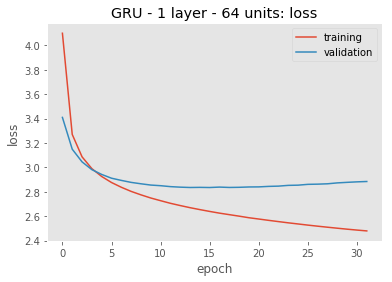

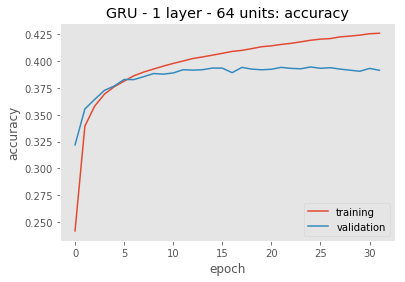

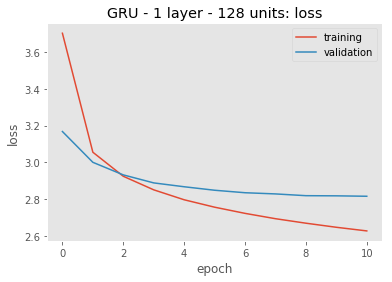

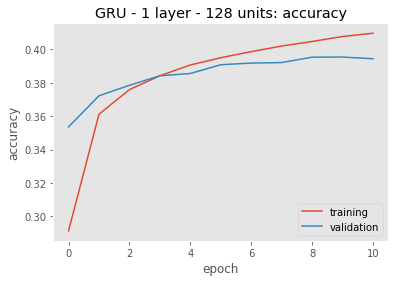

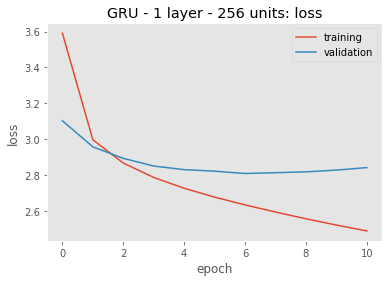

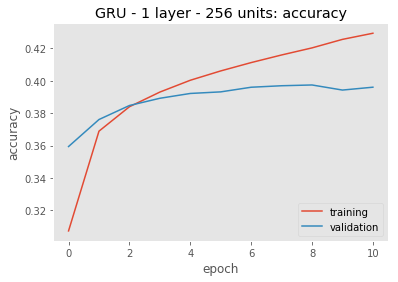

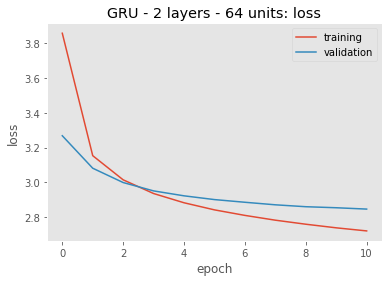

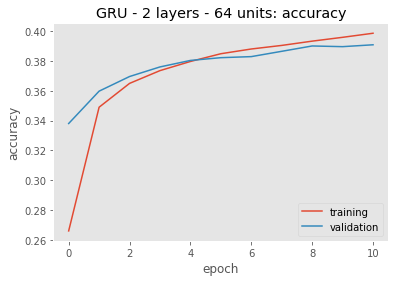

In [155]:
# Plotting learning curves for each of the 4 models
plot_learning_curves(models["GRU"].history, "GRU - 1 layer - 64 units")
plot_learning_curves(models["GRU_1_128_128"].history, "GRU - 1 layer - 128 units")
plot_learning_curves(models["GRU_1_256_128"].history, "GRU - 1 layer - 256 units")
plot_learning_curves(models["GRU_2_64_128"].history, "GRU - 2 layers - 64 units")

### Generate sentences

Now you will generate new sentences from your best performing model.

**Code** To achieve that, use the provided sample function below to generate new sentences from your model. You should start by constructing a sentence that starts with the 'START' artificial word and all other words being the 'PADD' artificial word. Then sample the first word from the corresponding probabilities given by your model. Add this word to the sentence and continue like this until you sample the 'END' artificial word or the maximum sentence length. [2 pts]

**Code** Generate 10 sentences for different sampling temperature in [0., 0.25, 0.5, 0.75, 1., 1.5., 2.]. [1 pt]

**7 Figures** For each temperature, use matplotlib imshow to plot the probablities of every word in one generated sentence (and only these words) at each time step. y-axis should be the words that are present in the sentence. x-axis the timesteps and the imshow value the probabilities given by the model for all words in the sentence at each timestep. Use the a colormap where 0 is white, e.g. cmap='Greys'. [2 pts]

**Code** Finally, seed your model with two different beginnings of max 4 words and let it generate 10 possible continuations (use sampling temperature of 1.). [2 pts]

**Question** What is the effect of sampling temperature on the generated sentences? [1 pt]

**Answer** 
Higher sampling temperatures correspond to more novel sentences and broader vocabulary usage, but with less regard to the learned grammar. Lower sampling temperatures follow the learned language more closely, but have a much lower likelihood for novel productions.

**Question** In terms of sampling a probability distribution, what does a sampling temperature of 0 corresponds to? [1 pt] 

**Answer** 
Sampling temperature of 0 corresponds to sampling only the highest likelihood transition, which leads to completely deterministic behavior.

**Question** In terms of sampling a probability distribution, what does a sampling temperature of 1. corresponds to? [1 pt] 

**Answer** 
Sampling temperature of 1 corresponds to sampling from the distribution with the probabilities given by the weights of the distribution. (sampling the distribution as is)

**Question** In terms of sampling a probability distribution, what does a very high sampling temperature corresponds to? [1 pt]

**Answer** 
A very high sampling temperature corresponds to uniform sampling of the distribution. (sampling the distribution with no regard to its weights)

**Question** Based on the plotted word probabilities, explain how a sentence is generated. [2 pts]

**Answer** A sentence is generated by starting with a subsentence and sampling from a distribution of transition probabilities. From the plots, we can see higher sampling temperatures cause us to 'miss' high probability words much more often, while low sampling temperatures cause us to pick very likely samples.

**Question** Do you observe timesteps with more than one word with non-zero probability? How do these probable words relate in terms of language? [1 pt]

**Answer** These words generally interchangeable in some way. For example, 'how' and 'i' are often non-zero probabilities at the beginning of a sentence, because they both are common ways to begin sentences. Additionally 'and' and ',' both have non-zero probabilities in similar places, because they are commonly used to separate clauses.

In [22]:
def sample(preds, temperature=1.):
    # helper function to sample an index from a probability array
    if temperature == 0.:
        return np.argmax(preds)
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


In [23]:
## Helper to predict the next word
def predict_next(prefix, model, sampler, dictionary=tokens, maxlen=maxlen):
    '''Produces the next word after a given subsentence, using a model and a sampling function.
    Arguments:
    prefix - (str) sentence of words used so far
    model - (keras.Model) RNN that can make predictions
    sampler - (function) function to sample 
    Returns:
    (str) next word predicted
    (np.ndarray) array of transition probabilities next word was selected from
    '''
    words = prefix.split(" ")
    input_tokens = np.zeros((1, maxlen-1))
    for i in range(len(words)):
        input_tokens[0,i] = tokens.index(words[i])
    preds = model.predict(input_tokens)
    next_distr = preds[0, len(words)-1]
    next_index = sampler(next_distr)
    return tokens[next_index], next_distr

In [24]:
## Helper to generate an entire sentence
def generate_sentence(model, temperature, maxlen=maxlen, verbose=0):
    '''Produces an entire sentence generated by the model
    Arguments:
    model - (keras.Model) RNN used to generate predictions
    temperature - (double) sampling temperature
    Returns:
    (list) list of all words in the sentence
    (list) list of transition probabilities from which sentence was generated
    '''
    sampler = lambda x: sample(x, temperature=temperature)
    sentence = ["START"]
    distrs = []
    while len(sentence) < maxlen and sentence[-1]!='END':
        prefix = ' '.join(sentence)
        next_word, next_distr = predict_next(prefix, model, sampler)
        sentence.append(next_word)
        distrs.append(next_distr)
        if verbose==2 and sentence[-1]!='END':
            print(' '.join([i for i in sentence if i!='START' and i!='END' and i!='PADD']))
    if verbose==1:
        print(' '.join([i for i in sentence if i!='START' and i!='END' and i!='PADD']))
    return sentence, distrs

In [564]:
temperatures = [0., 0.25, 0.5, 0.75, 1, 1.5, 2]
generated_sentences = [generate_sentence(RNNmodel, t) for t in temperatures]
[print(" ".join([w for w in s[0] if w!='END' and w!='START' and w!='PADD'])) for s in generated_sentences]

i am good . how are you ?
i am good , how are you ?
i am good how are you
i see , but i do just relax on the beach .
pretty good also and i just live by night beach .
no get tattoos what color do you take in
all day pasta are the vegetables there today i spend together his job , bed and volunteer in the


[None, None, None, None, None, None, None]

In [565]:
def plot_distrs(words, distrs, temp, dictionary=tokens):
    ## Get indices only of words
    words = words[1:]
    indices = [dictionary.index(i) for i in words]
    ## Make the y axis tick labels
    ylabels = list(set(zip(indices, words)))
    ylabels.sort()
    ylabels = [l[1] for l in ylabels]
    ## Isolate only transition probabilities of words in this sentence
    distrs = [[w for i,w in enumerate(d) if i in indices] for d in distrs]
    distrs = np.transpose(np.array(distrs))
    ## Plot the imshow plot
    fig, ax1 = plt.subplots(1,1)
    ax1.imshow(distrs, cmap='Greys')
    ax1.set_yticks(range(len(ylabels)))
    ax1.set_yticklabels(ylabels)
    ax1.set_title('Temperature = {0}: "{1}"'.format(temp, ' '.join([i for i in words if i!='START' and i!='END' and i!='PADD'])))

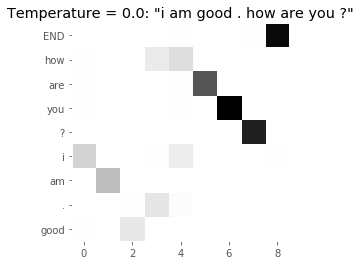

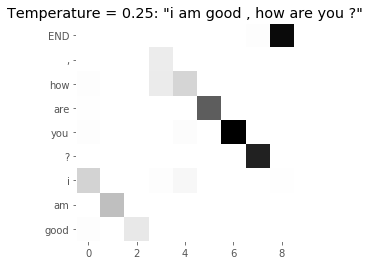

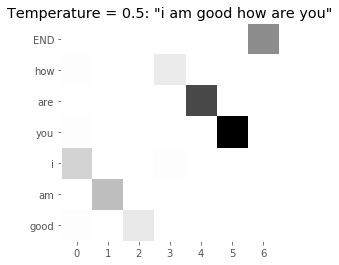

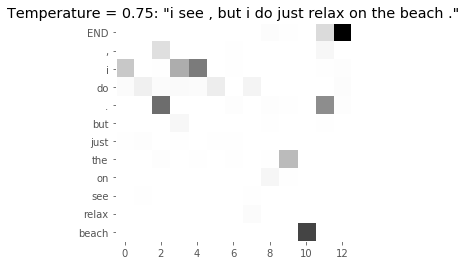

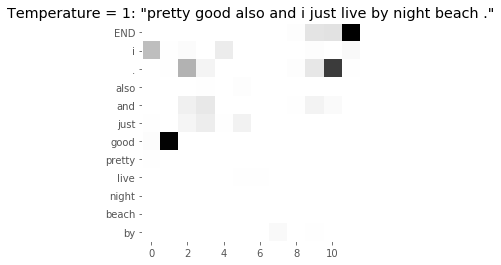

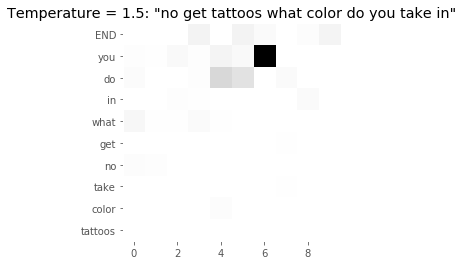

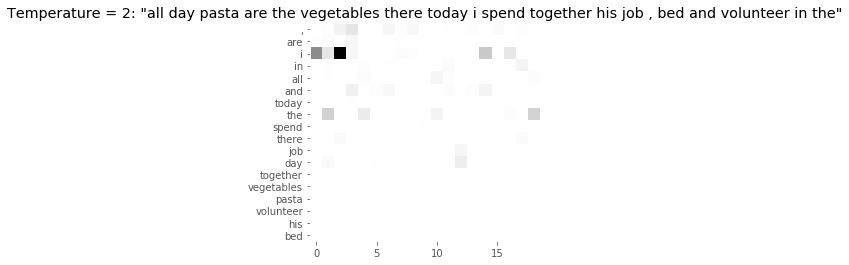

In [566]:
for i, t in enumerate(temperatures):
    plot_distrs(*generated_sentences[i], t)

###  Word embedding visualization

Here, you are asked to visualize the embedding layer. 

**Code** To do that, project in 2D the embedding vectors for different words. Use t-SNE, a projection that conserve the neighborhood relationships between vectors. HINT: Build a Keras model that takes as input a list of words and outputs a list of vector embeddings as learned by your best performing model. Use t-SNE dimensionality reduction (from sklearn.manifold import TSNE). [2 pts]

**Figure** Plot the projection of the first 200 most frequent words in a 2D plot. On the plot, write the words. [2 pt] 

**Question** Do you observe clusters of words with similar meaning or role in language? Report three of them here. [1 pt]

**Answer**

**Question** Why is having similar vector representation for similar words a good approach for such models? Explain using the example clusters from before and argue in terms of prediction accuracy and/or generalization. [2 pts]

**Answer**

In [25]:
model_input = RNNmodel.layers[0]
output = RNNmodel.layers[1]

NameError: name 'RNNmodel' is not defined

In [89]:
embedding_model = Model(inputs=[model_input.input], outputs = [output(model_input.output)])
embedding_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 19)                0         
_________________________________________________________________
embedding (Embedding)        (None, 19, 128)           129280    
Total params: 129,280
Trainable params: 129,280
Non-trainable params: 0
_________________________________________________________________


## Chatbot

Finally, you will construct a model with which you can chat. The network will take as input a sentence and output a response.

**Code** For that, you should go back to your original data and construct a new dataset containing pairs of sentences, where each pair is a sentence and its answer. Be careful to not include any pair of sentences that contains words not present in your filtered dictionary. [2 pts]

**Code** You should then tokenize, padd, truncate each sentence. Only the answers need the 'START' and 'END' artificial words. [1 pt]

We provide you with a possible model, you are welcome to change it. This model uses an LSTM layer to encode the first sentence (the context). The final state of this LSTM layer is transfered to initialize the state of a decoder LSTM layer from which the answer sentence will be generated. 

**Code** Train your chatbot model on your dataset. [1 pt]

**Code** Adapt your sentence generation code from before so that you can generate an answer given a context sentence from your model. [2 pts] 

**Code** After training, randomly select 10 context-answers pairs from your data and show both the real answer (the one from the data) and the generated one for two different sampling temperatures (e.g. 0.5 and 1.0). [2 pts]

**Question** How similar are the generated answers and the real ones? Does your model provide probable answers (given the dataset)? Report here one good and one bad example. [2 pts]

**Answer**

**Question** Which sampling temperature gives better answers? why? [2 pts]

**Answer**

**Question** Would it be good if your model was able to reproduce exactly each real answer? Why? [1 pt]

**Answer**

**Code** Entertain yourself with your model. Write some code to chat with your bot, let it discuss with itself, ... be creative! [2 **bonus** pts]




In [273]:
def make_pairs(conv):
    calls = conv[:-1]
    calls = [[tokens.index(w) for w in sentence.split(' ')] for sentence in calls]
    calls = pad_sequences(calls, maxlen=maxlen-2)
    responses = conv[1:]
    responses = [[1]+[tokens.index(w) for w in sentence.split(' ')]+[2] for sentence in responses]
    responses = pad_sequences(responses, maxlen=maxlen, padding='post', truncating='post')
    return list(list(pair) for pair in zip(calls, responses))
convs = [make_pairs(conv) for conv in filtered if len(conv)>1]
pairs = [exchange for conversation in convs for exchange in conversation]

In [274]:
calls = np.array([i[0] for i in pairs])
responses = np.array([i[1] for i in pairs])
calls.shape, responses.shape

((41935, 18), (41935, 20))

In [275]:
X = [calls, responses[:,:-1]]
T = np.zeros(X[1].shape + (len(tokens),))
for i, sentence in enumerate(responses[:,1:]):
    for j, word in enumerate(sentence):
        T[i,j,word] = 1
X[0].shape, X[1].shape, T.shape

((41935, 18), (41935, 19), (41935, 19, 1010))

In [29]:
# TODO: Select actual best embeddings layer
#load
with open("RNNmodel_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "rb") as file:
    RNNmodel_log = pickle.load(file)
RNNmodel = load_model("RNNmodel_"+str(embedding_size)+'_'+str(hidden_size))
best_embedding = RNNmodel.get_layer("embedding")

In [30]:
context = Input(shape=(maxlen-2,), name="input_context")
shared_embedding = best_embedding
context_embedding = shared_embedding(context)

encoder_y, encoder_h, encoder_c = LSTM(hidden_size, 
            return_sequences=False,
            return_state=True,
            stateful=False,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            go_backwards=True,
            name="encoder")(context_embedding)

answer = Input(shape=(maxlen-1,), name="input_answer")
answer_embedding = shared_embedding(answer)

decoder_input = answer_embedding
decoder = LSTM(hidden_size, 
            return_sequences=True,
            stateful=False,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            name="decoder")(answer_embedding, initial_state=[encoder_h, encoder_c])
# decoder2 = LSTM(hidden_size, 
#             return_sequences=True,
#             stateful=False,
#             dropout=dropout,
#             recurrent_dropout=recurrent_dropout,
#             name="decoder2")(decoder)

R = TimeDistributed(Dense(embedding_size, activation='relu'), name='readout')(decoder)
Y = TimeDistributed(Dense(len(tokens), activation='softmax'), name='output')(R)

Chatbot = Model(inputs = [context, answer], outputs = [Y])
Chatbot.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
Chatbot.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_answer (InputLayer)       (None, 19)           0                                            
__________________________________________________________________________________________________
input_context (InputLayer)      (None, 18)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           multiple             129280      input_context[0][0]              
                                                                 input_answer[0][0]               
__________________________________________________________________________________________________
encoder (LSTM)                  [(None, 64), (None,  49408       embedding[1][0]                  
__________

In [193]:
## TODO: Parameterize this, run validation
t = Chatbot.fit(x=X, y=T, epochs=epochs)

Epoch 1/32
41935/41935 [==============================] - 133s 3ms/step - loss: 2.2156 - acc: 0.4794
Epoch 2/32
41935/41935 [==============================] - 141s 3ms/step - loss: 2.2079 - acc: 0.4805
Epoch 3/32
41935/41935 [==============================] - 126s 3ms/step - loss: 2.2006 - acc: 0.4817
Epoch 4/32
41935/41935 [==============================] - 129s 3ms/step - loss: 2.1931 - acc: 0.4826
Epoch 5/32
41935/41935 [==============================] - 129s 3ms/step - loss: 2.1862 - acc: 0.4843
Epoch 6/32
41935/41935 [==============================] - 129s 3ms/step - loss: 2.1799 - acc: 0.4848
Epoch 7/32
41935/41935 [==============================] - 130s 3ms/step - loss: 2.1733 - acc: 0.4855
Epoch 8/32
41935/41935 [==============================] - 130s 3ms/step - loss: 2.1669 - acc: 0.4869
Epoch 9/32
41935/41935 [==============================] - 130s 3ms/step - loss: 2.1613 - acc: 0.4876
Epoch 10/32
41935/41935 [==============================] - 132s 3ms/step - loss: 2.1553 - a

In [315]:
## Helper to predict the next word
def predict_next_with_context(prefix, model, context, sampler, dictionary=tokens, maxlen=maxlen):
    '''Produces the next word after a given subsentence and a given context, using a model and a sampling function.
    Arguments:
    prefix - (str) sentence of words used so far
    model - (keras.Model) RNN that can make predictions
    context - (list) encoded context of preceding sentence (caller's sentence in call/response)
    sampler - (function) function to sample 
    Returns:
    (str) next word predicted
    (np.ndarray) array of transition probabilities next word was selected from
    '''
    words = prefix.split(" ")
    input_tokens = np.zeros((1, maxlen-1))
    for i in range(len(words)):
        input_tokens[0,i] = tokens.index(words[i])
    preds = model.predict([context, input_tokens])
    next_distr = preds[0, len(words)-1]
    next_index = sampler(next_distr)
    return tokens[next_index], next_distr

def predict_response(call, model, temperature, maxlen=maxlen, verbose=0):
    '''Produces an entire sentence generated by the Chatbot model
    Arguments:
    call - (string) the 'calling' sentence which is used to generate the context in the model
    model - (keras.Model) RNN used to generate predictions
    temperature - (double) sampling temperature
    Returns:
    (list) list of all words in the sentence
    (list) list of transition probabilities from which sentence was generated
    '''
    call = call.split(' ')
    call = [tokens.index(word) for word in call]
    call = np.array(pad_sequences([call], maxlen-2, padding='pre', truncating='pre'))
    sampler = lambda x: sample(x, temperature=temperature)
    sentence = ["START"]
    distrs = []
    while len(sentence) < maxlen and sentence[-1]!='END':
        prefix = ' '.join(sentence)
        next_word, next_distr = predict_next_with_context(prefix, model, call, sampler)
        sentence.append(next_word)
        distrs.append(next_distr)
        if verbose==2 and sentence[-1]!='END':
            print(' '.join([i for i in sentence if i!='START' and i!='END' and i!='PADD']))
    if verbose==1:
        print(' '.join([i for i in sentence if i!='START' and i!='END' and i!='PADD']))
    return sentence, distrs

In [316]:
predict_response('hey how have you been ? it has been a while !', Chatbot, 1)[0]

/Users/marshallcooper/anaconda3/envs/cs456env/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


['START', 'soon', '!', 'what', 'did', 'you', 'do', 'on', 'it', '?', 'END']

In [317]:
def repl(temperature=1):
    print("You:", end = ' ')
    x = input()
    while x!="quit":
        call = (''.join([' ' + i + ' ' if i in ",.?!" else i for i in x.lower()])).split()
        call = ' '.join([i for i in call if i in tokens])
        if len(call)==0:
            call = 'PADD'
        prediction = predict_response(call, Chatbot, temperature)
        bot_output = ' '.join([w for w in prediction[0] if w!='END' and w!='START' and w!='PADD'])
        print("CzatBaut:", bot_output)
        print("You:", end = ' ')
        x = input()

In [327]:
repl(0)

You: that sounds like fun . i am doing pretty good . where are you from
CzatBaut: i live in the city too . i love to read
You: that sounds good . what do you do for fun
CzatBaut: i love to read and play video games
You: quit


In [326]:
filtered

[['you must be very fast . hunting is one of my favorite hobbies .',
  'that is awesome . do you have a favorite season or time of year ?',
  'what is your favorite meat to eat ?'],
 ['hi , how are you doing today ?',
  'i am spending time with my 4 sisters what are you up to',
  'wow , four sisters . just watching game of thrones .',
  'i agree . what do you do for a living ?',
  'that is cool my mom does the same thing',
  'tell me more about yourself',
  'i enjoy hanging with my mother she is my best friend',
  'that is nice . moms are pretty cool too .'],
 ['i can tell . i am not , you can see me in some tv shows',
  'wow , i wish i had a big family . i grew up in a very small town .',
  'i did too . i do not get along with mine . they have no class .',
  'those are really yummy too , but not my favorite .'],
 ['i also cook , and i ride my bike to work .'],
 ['how are you doing today',
  'i like to watch kids',
  'how does that feel for you',
  'i bet that it does',
  'anyway . wha